In [1]:
import numpy as np 
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
from haversine import haversine

import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

bold = ['\033[1m', '\033[0m']

# Read files
path = '/kaggle/input/playground-series-s3e1/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
ss = pd.read_csv(path+'sample_submission.csv')

from sklearn.datasets import fetch_california_housing as fch
sklearn_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
sklearn_df['MedHouseVal'] = fch()['target']

# Show all columns
pd.set_option('display.max_columns', None)

![](https://www.bankrate.com/2022/06/14113029/buying-a-house-in-california.jpg?auto=webp&optimize=high&crop=16:9&width=912)

<a href="https://www.bankrate.com/real-estate/buying-a-house-in-california/">Photo source</a>

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>EDA</b></div>

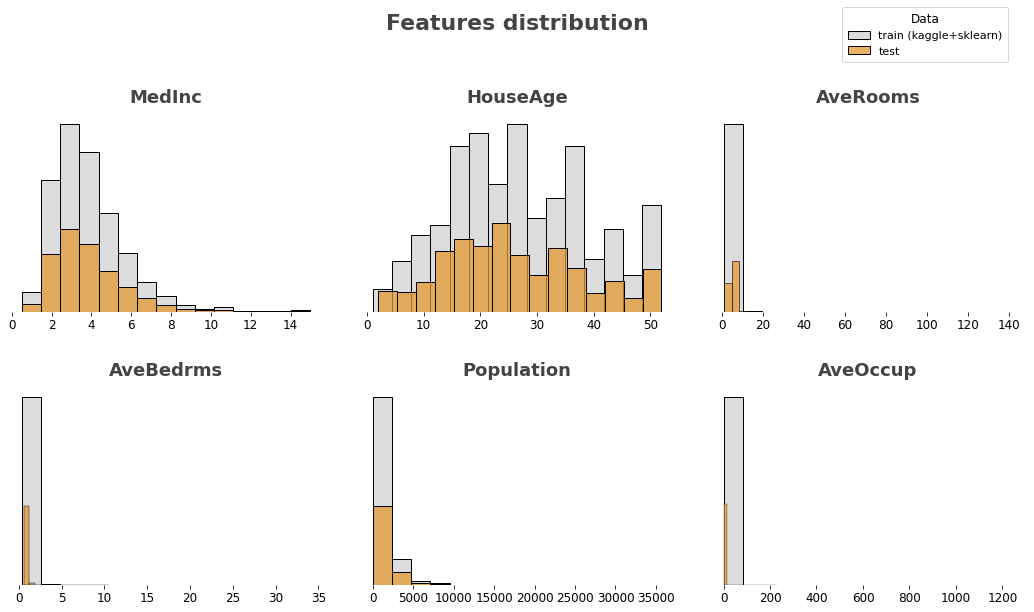

In [2]:
df_for_plot = pd.concat([train, sklearn_df], 
                        ignore_index=True)
fig = plt.figure(figsize = (15, 8))
for i, col in enumerate(train.columns[1:7]):
    plt.subplot(2,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.histplot(df_for_plot[col], 
                     color='#d1d1d1', bins=15, label='train (kaggle+sklearn)')
    sns.histplot(test[col], 
                     color='#e29930', bins=15, label='test')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['train (kaggle+sklearn)', 'test'], bbox_to_anchor=(0.96, 1.1), 
           ncol=1, borderpad=0.5, frameon=True, fontsize=11,
                   title='Data', title_fontsize=12)
plt.figtext(0.5, 1.05, 'Features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

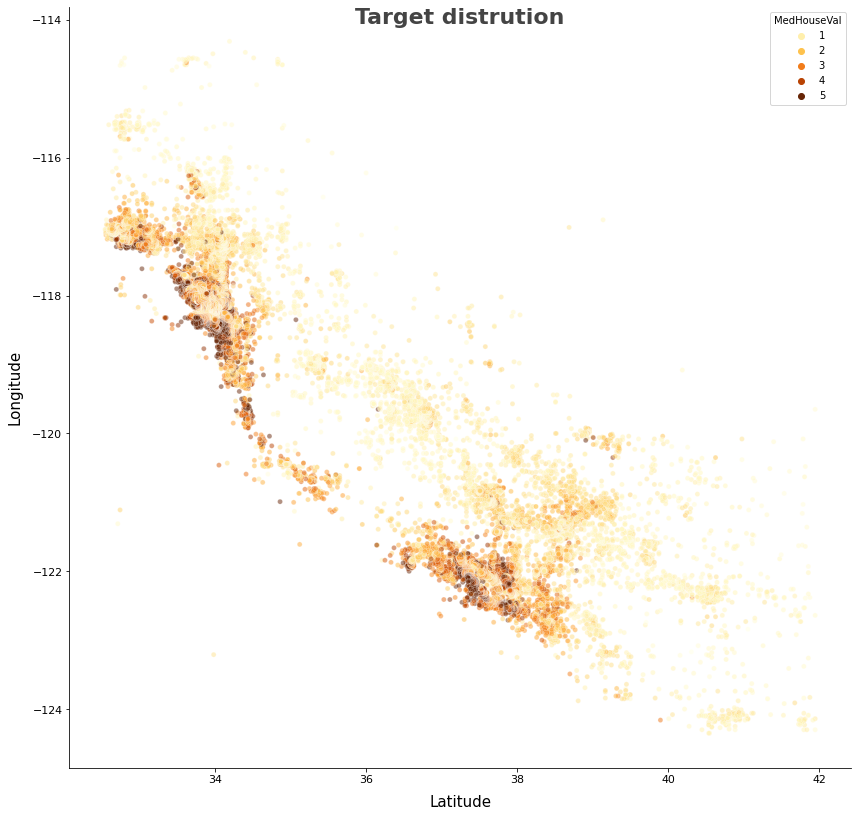

In [3]:
plt.figure(figsize=(14, 14))
plt.title('Target distrution', size=22, y=0.97, fontname='Calibri', 
          fontweight='bold', color='#444444')
a = sns.scatterplot(data=df_for_plot, x='Latitude', y='Longitude', hue='MedHouseVal', 
                    palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Latitude', labelpad=10, fontsize=15)
plt.ylabel('Longitude', labelpad=10, fontsize=15)

for j in ['right', 'top']:
    a.spines[j].set_visible(False)
    
plt.show()

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>Preprocessing</b></div>

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Generated data</span></b>

<p style="text-align:justify;">
It is worth starting with the definition of the generated data. As correctly noted in the <a href="https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376043"><b>discussion</b></a>, this really improves the results of the models. Then merge the data and delete id's. I will also move three houses from the distant ocean to the mainland.
</p>

In [4]:
sklearn_df['is_generated'] = 0
train['is_generated'] = 1
test['is_generated'] = 1

train.drop('id', axis=1, inplace=True)
train = pd.concat([train, sklearn_df], 
                  ignore_index=True)
test.drop('id', axis=1, inplace=True)

train.loc[33228,['Latitude','Longitude']] = [32.74, -117]
train.loc[34363,['Latitude','Longitude']] = [32.71, -117]
train.loc[20991,['Latitude','Longitude']] = [34.2, -119]

df = pd.concat([train, test], axis=0, ignore_index=True)
coordinates = df[['Latitude', 'Longitude']].values

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Encoding trick</span></b>

Idea from this <a href="https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376210"><b>discussion</b></a>


In [5]:
emb_size = 20
precision = 1e6 

latlon = np.expand_dims(coordinates, axis=-1) 

m = np.exp(np.log(precision) / emb_size) 
angle_freq = m ** np.arange(emb_size) 
angle_freq = angle_freq.reshape(1, 1, emb_size) 

latlon = latlon * angle_freq 
latlon[..., 0::2] = np.cos(latlon[..., 0::2]) 
latlon[..., 1::2] = np.sin(latlon[..., 1::2]) 
latlon = latlon.reshape(-1, 2 * emb_size) 

df['exp_latlon1'] = [lat[0] for lat in latlon]
df['exp_latlon2'] = [lat[1] for lat in latlon]

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Clustering</span></b>

In [6]:
clustering = KMeans(n_clusters=20, 
                    max_iter=1111, 
                    random_state=228).fit(coordinates)

cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
def cluster_features(df):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), cc, unit='ft'), axis=1)
    return df
df = cluster_features(df)

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Coordinates with PCA and UMAP</span></b>

In [7]:
pca = PCA().fit(coordinates)
df['pca_lat'] = pca.transform(coordinates)[:,0]
df['pca_lon'] = pca.transform(coordinates)[:,1]

umap = UMAP(n_components=2, 
            n_neighbors=50, 
            random_state=228).fit(coordinates)
df['umap_lat'] = umap.transform(coordinates)[:,0]
df['umap_lon'] = umap.transform(coordinates)[:,1]

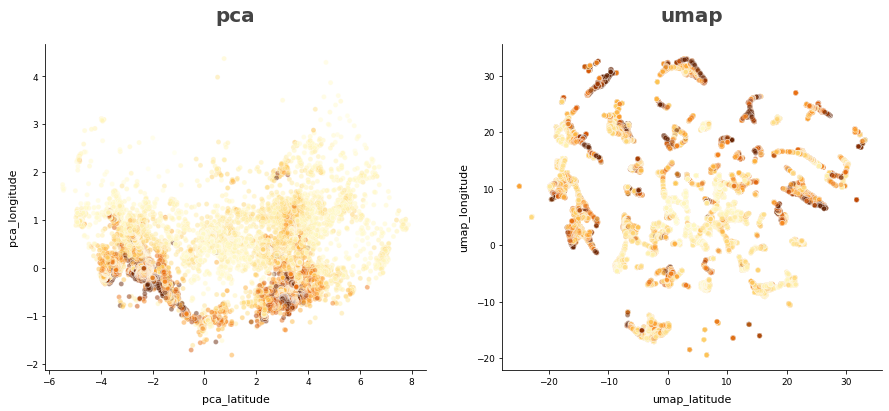

In [8]:
train = df.iloc[:-len(test),:]

fig = plt.figure(figsize=(15, 6))
for i, col in enumerate(['pca', 'umap']):
    plt.subplot(1,2,i+1)
    plt.title(col, size=20, y=1.05, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.scatterplot(data=train, x=f'{col}_lat', y=f'{col}_lon', hue='MedHouseVal', 
                        palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'{col}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'{col}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()
    
plt.show()

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Cartesian coordinates rotation</span></b>

<p style="text-align:justify;">
These features have given an incredibly large increase in the metric.
</p>

In [9]:
df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                  (np.sin(np.radians(15)) * df['Latitude'])
    
df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) + \
                  (np.sin(np.radians(15)) * df['Longitude'])
    
df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                  (np.sin(np.radians(30)) * df['Latitude'])
    
df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) + \
                  (np.sin(np.radians(30)) * df['Longitude'])
    
df['rot_45_x'] = (np.cos(np.radians(44)) * df['Longitude']) + \
                  (np.sin(np.radians(45)) * df['Latitude'])

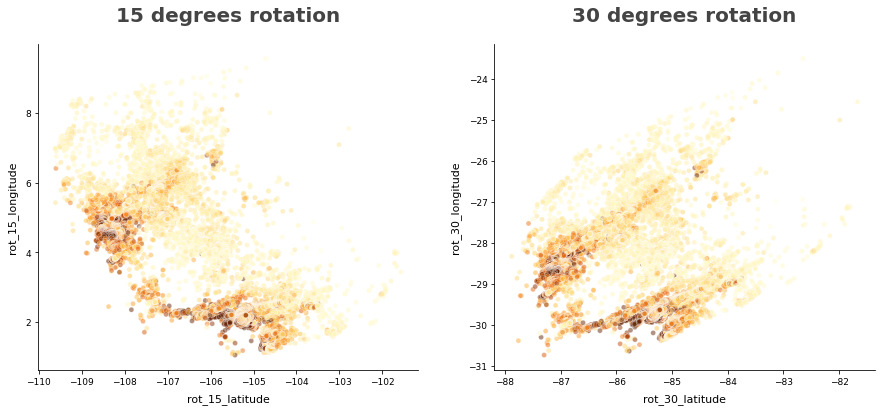

In [10]:
train = df.iloc[:-len(test),:]

fig = plt.figure(figsize=(15, 6))
for i, col in enumerate(['15', '30']):
    plt.subplot(1,2,i+1)
    plt.title(f'{col} degrees rotation', size=20, y=1.05, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.scatterplot(data=train, x=f'rot_{col}_x', y=f'rot_{col}_y', hue='MedHouseVal', 
                        palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'rot_{col}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'rot_{col}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()
    
plt.show()

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Location of coordinates</span></b>

<p style="text-align:justify;">
Thanks to this wonderful library, we can easily determine in which locality the place is located.
</p>

In [11]:
pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=be289c6a7664d2cf1b48cd93c60050a92d2ea433be8390abe797f9f61d720bb8
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse_geocoder
Note: you may need to restart the kernel to use updated packages.


In [12]:
import reverse_geocoder as rg

coordinates = list(zip(df['Latitude'], df['Longitude']))
results = rg.search(coordinates)
df['place'] = [x['admin2'] for x in results]

places = ['Los Angeles County', 'Orange County', 'Kern County',
          'Alameda County', 'San Francisco County', 'Ventura County',
          'Santa Clara County', 'Fresno County', 'Santa Barbara County',
          'Contra Costa County', 'Yolo County', 'Monterey County',
          'Riverside County', 'Napa County']

def replace(x):
    if x in places:
        return x
    else:
        return 'Other'
    
df['place'] = df['place'].apply(lambda x: replace(x))
le = LabelEncoder()
df['place'] = le.fit_transform(df['place'])

Loading formatted geocoded file...


<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Distance to cities and coast points</span></b>

In [13]:
SC = (38.576931, -121.494949)
SF = (37.780080, -122.420160)
SJ = (37.334789, -121.888138)
LA = (34.052235, -118.243683)
SD = (32.715759, -117.163818)

df['dist_SC'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SC, unit='ft'), axis=1)
df['dist_SF'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
df['dist_SJ'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
df['dist_LA'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
df['dist_SD'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
df['dist_nearest_city'] = df[['dist_SC', 'dist_SF', 'dist_SJ', 
                              'dist_LA', 'dist_SD']].min(axis=1)

In [19]:
from shapely.geometry import LineString, Point

coast_points = LineString([(32.664, -117.161), (33.206, -117.383),
                           (33.777, -118.202), (34.463, -120.014),
                           (35.427, -120.881), (35.928, -121.489),
                           (36.982, -122.028), (37.611, -122.491),
                           (38.355, -123.060), (39.792, -123.821),
                           (40.799, -124.188), (41.755, -124.197)])

df['dist_to_coast'] = df.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#e29930;font-size:200%;font-family:Calibri'> Final preprocessing</span></b>

In [20]:
train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:].drop('MedHouseVal', axis=1).reset_index(drop=True)

X = train.drop('MedHouseVal', axis=1)
y = train['MedHouseVal']

seed = 228
FOLDS = 10

In [16]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def f_importance_plot(f_imp):
    fig = plt.figure(figsize = (15, 0.35*len(f_imp)))
    plt.title('Feature importances', size=25, y=1.05, 
              fontname='Calibri', fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='Blues_d', linestyle="-", 
                    linewidth=1, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.show()

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>LGBM</b></div>


--- FOLD 1 ---
[1000]	train's rmse: 0.452637	val's rmse: 0.511719
[2000]	train's rmse: 0.416843	val's rmse: 0.507637
[3000]	train's rmse: 0.389606	val's rmse: 0.507346
--- RMSE: 0.507239 | best iteration: 2749 ---

--- FOLD 2 ---
[1000]	train's rmse: 0.453658	val's rmse: 0.510875
[2000]	train's rmse: 0.418896	val's rmse: 0.507013
[3000]	train's rmse: 0.391136	val's rmse: 0.5065
[4000]	train's rmse: 0.367161	val's rmse: 0.506048
--- RMSE: 0.505932 | best iteration: 3824 ---

--- FOLD 3 ---
[1000]	train's rmse: 0.451613	val's rmse: 0.522093
[2000]	train's rmse: 0.41684	val's rmse: 0.518357
[3000]	train's rmse: 0.38951	val's rmse: 0.517689
[4000]	train's rmse: 0.365726	val's rmse: 0.517386
--- RMSE: 0.517347 | best iteration: 3949 ---

--- FOLD 4 ---
[1000]	train's rmse: 0.453117	val's rmse: 0.506066
[2000]	train's rmse: 0.417731	val's rmse: 0.503055
[3000]	train's rmse: 0.389895	val's rmse: 0.50297
--- RMSE: 0.502785 | best iteration: 2700 ---

--- FOLD 5 ---
[1000]	train's rmse: 0.4548

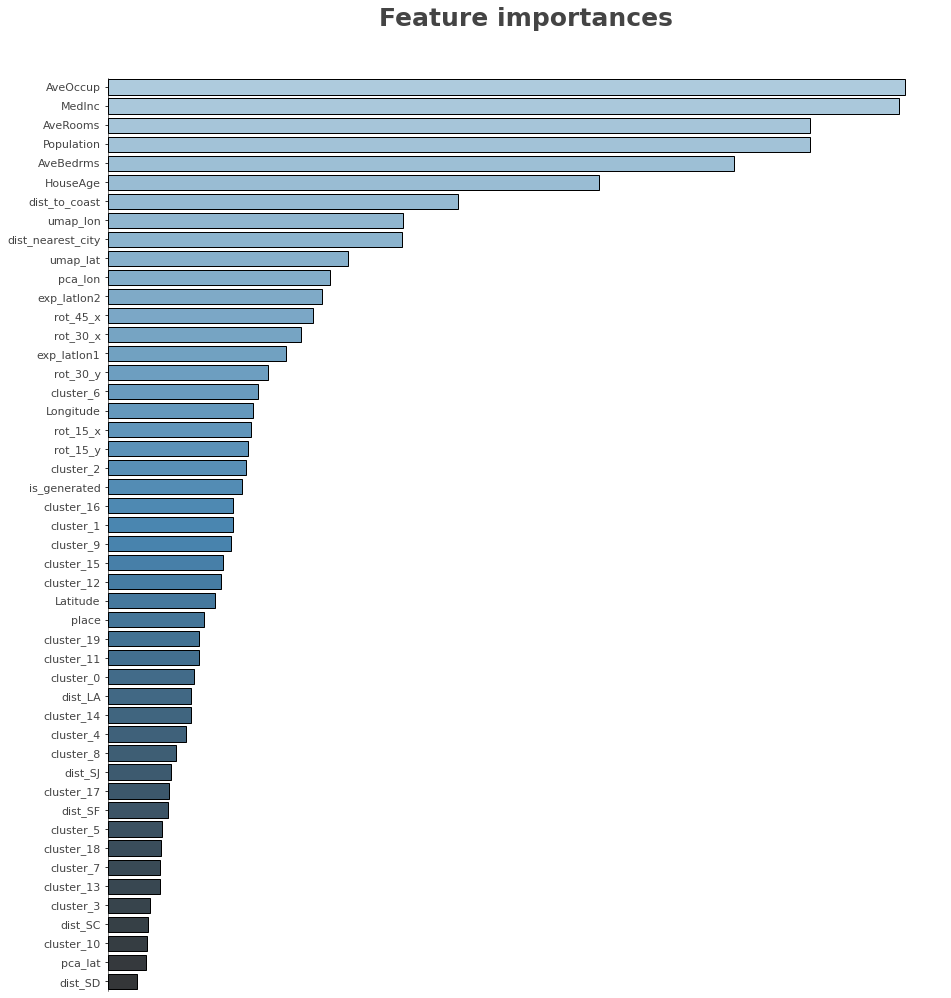

In [21]:
lgb_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'min_data_in_leaf': 36, 
    'num_leaves': 100, 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.89, 
    'bagging_freq': 5, 
    'lambda_l2': 28,
    
    'seed': seed,
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'device': 'cpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'n_jobs': -1,
    'metric': 'rmse',
    'verbose': -1
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f'\n--- FOLD {fold+1} ---')
        
    lgb_train = lgb.Dataset(data=X.iloc[train_idx], 
                            label=y.iloc[train_idx],
                            categorical_feature=['place'])
    lgb_valid = lgb.Dataset(data=X.iloc[val_idx], 
                            label=y.iloc[val_idx],
                            categorical_feature=['place'],
                            reference=lgb_train)

    model = lgb.train(params=lgb_params, 
                      train_set=lgb_train, 
                      num_boost_round=50000,
                      valid_sets=[lgb_train, lgb_valid], 
                      valid_names=['train', 'val'],
                      verbose_eval=False,
                      callbacks=[lgb.log_evaluation(1000),
                                 lgb.early_stopping(1000, verbose=False)])
    
    f_imp['fold_'+str(fold+1)] = model.feature_importance()
    b_itr = model.best_iteration
    
    val_preds = model.predict(X.iloc[val_idx], num_iteration=b_itr)
    val_score = rmse(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test, num_iteration=b_itr) / FOLDS
    print(f'--- RMSE: {bold[0]}{round(val_score, 6)}{bold[1]} | best iteration: {bold[0]}{b_itr}{bold[1]} ---')
    
    del lgb_train, lgb_valid, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean RMSE: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')

f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
f_imp.sort_values('avg_imp', ascending=False, inplace=True)
f_importance_plot(f_imp)

In [22]:
lgbm_preds = predictions.copy()
ss['MedHouseVal'] = predictions
ss.to_csv('lgbm_submission_final.csv', index=False)

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>CatBoost</b></div>


--- FOLD 1 ---
0:	learn: 1.1494347	test: 1.1469409	best: 1.1469409 (0)	total: 208ms	remaining: 2h 53m 22s
3000:	learn: 0.4548202	test: 0.5134464	best: 0.5134440 (2998)	total: 7m 44s	remaining: 2h 1m 12s
6000:	learn: 0.4079791	test: 0.5093833	best: 0.5093801 (5999)	total: 15m 26s	remaining: 1h 53m 11s
9000:	learn: 0.3729913	test: 0.5085277	best: 0.5085172 (8967)	total: 23m 12s	remaining: 1h 45m 41s
Stopped by overfitting detector  (777 iterations wait)

bestTest = 0.5085072842
bestIteration = 9751

Shrink model to first 9752 iterations.
--- RMSE: 0.508507 | best iteration: 9751 ---

--- FOLD 2 ---
0:	learn: 1.1490344	test: 1.1507757	best: 1.1507757 (0)	total: 148ms	remaining: 2h 3m 30s
3000:	learn: 0.4553652	test: 0.5105542	best: 0.5105542 (3000)	total: 7m 42s	remaining: 2h 46s
6000:	learn: 0.4084355	test: 0.5069440	best: 0.5069440 (6000)	total: 15m 23s	remaining: 1h 52m 54s
9000:	learn: 0.3730325	test: 0.5060002	best: 0.5059131 (8377)	total: 23m 8s	remaining: 1h 45m 24s
Stopped by ove

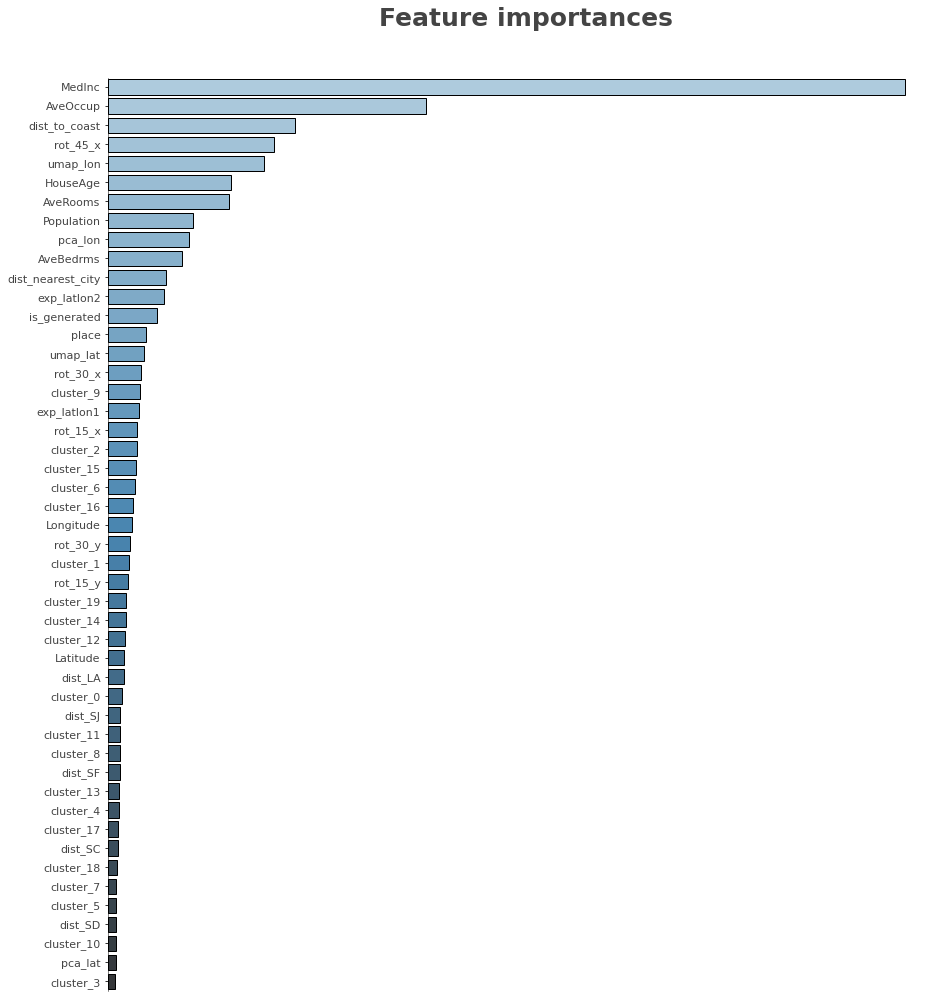

In [23]:
cb_params = {
    'depth': 9,
    'learning_rate': 0.01,
    'rsm': 0.88,
    'subsample': 0.795,
    'l2_leaf_reg': 8,
    'min_data_in_leaf': 35,
    'random_strength': 0.63,
    
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'random_seed': seed,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f'\n--- FOLD {fold+1} ---')
    
    cb_train = cb.Pool(data=X.iloc[train_idx],
                       label=y.iloc[train_idx],
                       cat_features=['place'])
    cb_valid = cb.Pool(data=X.iloc[val_idx],
                       label=y.iloc[val_idx],
                       cat_features=['place'])
    
    model = cb.train(params=cb_params,
                     dtrain=cb_train,
                     num_boost_round=50000,
                     evals=cb_valid, 
                     early_stopping_rounds=777,
                     verbose=3000)
    
    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    b_itr = model.get_best_iteration()
    
    val_preds = model.predict(cb_valid)
    val_score = rmse(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test) / FOLDS
    print(f'--- RMSE: {bold[0]}{round(val_score, 6)}{bold[1]} | best iteration: {bold[0]}{b_itr}{bold[1]} ---')
    
    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean RMSE: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')

f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
f_imp.sort_values('avg_imp', ascending=False, inplace=True)
f_importance_plot(f_imp)

In [24]:
cb_preds = predictions.copy()
ss['MedHouseVal'] = predictions
ss.to_csv('cb_submission_final.csv', index=False)

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>XGB</b></div>

In [25]:
def df_xgb(df):
    df = pd.concat([df, pd.get_dummies(df['place'], 
                                       prefix='place')], axis=1)
    df.drop('place', axis=1, inplace=True)
    return df

X = df_xgb(X)
test = df_xgb(test)


--- FOLD 1 ---
[0]	train-rmse:1.93813	eval-rmse:1.93325
[5000]	train-rmse:0.43890	eval-rmse:0.50949
[10000]	train-rmse:0.43303	eval-rmse:0.50866
[14119]	train-rmse:0.43050	eval-rmse:0.50839
--- RMSE: 0.508355 | best iteration: 13121 ---

--- FOLD 2 ---
[0]	train-rmse:1.93658	eval-rmse:1.94695
[5000]	train-rmse:0.43886	eval-rmse:0.50701
[8733]	train-rmse:0.43505	eval-rmse:0.50676
--- RMSE: 0.506725 | best iteration: 7735 ---

--- FOLD 3 ---
[0]	train-rmse:1.93913	eval-rmse:1.92466
[5000]	train-rmse:0.43849	eval-rmse:0.52121
[10000]	train-rmse:0.43351	eval-rmse:0.52067
[13167]	train-rmse:0.43157	eval-rmse:0.52059
--- RMSE: 0.520547 | best iteration: 12168 ---

--- FOLD 4 ---
[0]	train-rmse:1.93747	eval-rmse:1.93939
[5000]	train-rmse:0.43965	eval-rmse:0.50345
[6817]	train-rmse:0.43705	eval-rmse:0.50336
--- RMSE: 0.503322 | best iteration: 5819 ---

--- FOLD 5 ---
[0]	train-rmse:1.93742	eval-rmse:1.93995
[5000]	train-rmse:0.43951	eval-rmse:0.50547
[10000]	train-rmse:0.43403	eval-rmse:0.50

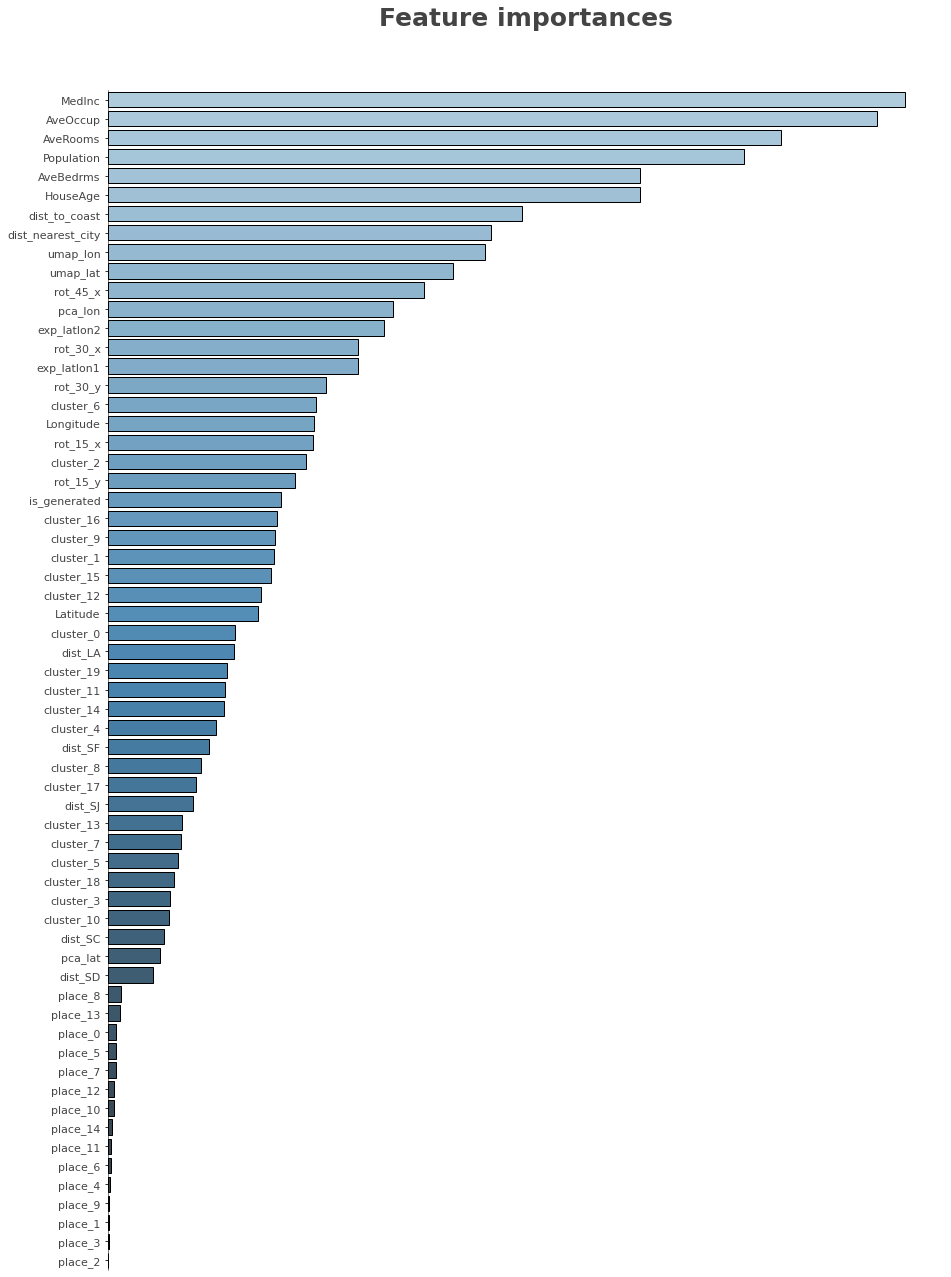

In [26]:
xgb_params = {
    'max_depth': 9,
    'eta': 0.01,
    'colsample_bytree': 0.66,
    'subsample': 0.76,
    'min_child_weight': 22,
    'lambda': 16, 
    'gamma': 1,
    
    'tree_method': 'gpu_hist',
    'booster': 'gbtree',
    'predictor':'gpu_predictor',
    'seed': seed,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f'\n--- FOLD {fold+1} ---')
    
    dtrain = xgb.DMatrix(X.iloc[train_idx], label=y.iloc[train_idx])
    dvalid = xgb.DMatrix(X.iloc[val_idx], label=y.iloc[val_idx])
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params=xgb_params, 
                      dtrain=dtrain, 
                      num_boost_round=50000,
                      evals=watchlist, 
                      verbose_eval=5000,
                      callbacks=[xgb.callback.EarlyStopping(rounds=1000,
                                                            data_name='eval',
                                                            maximize=False,
                                                            save_best=True)])
    
    fi = model.get_score(importance_type='weight')
    fi = pd.DataFrame({'feature':fi.keys(),f'importance_{fold}':fi.values()})
    f_imp = f_imp.merge(fi, on='feature', how='left').fillna(0)
    b_itr = model.best_ntree_limit
    
    val_preds = model.predict(dvalid)
    val_score = rmse(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(xgb.DMatrix(test)) / FOLDS
    print(f'--- RMSE: {bold[0]}{round(val_score, 6)}{bold[1]} | best iteration: {bold[0]}{b_itr}{bold[1]} ---')
    
    del dtrain, dvalid, watchlist, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean RMSE: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')

f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
f_imp.sort_values('avg_imp', ascending=False, inplace=True)
f_importance_plot(f_imp)

In [27]:
xgb_preds = predictions.copy()
ss['MedHouseVal'] = predictions
ss.to_csv('xgb_submission_final.csv', index=False)

# <div style="background-color:#e29930;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>Blending + rounding</b></div>

In [28]:
ss['MedHouseVal'] = lgbm_preds*0.35 + cb_preds*0.3 + xgb_preds*0.35

In [29]:
train['MedHouseVal'].nunique()

3842

<p style="text-align:justify;">
As you can see, the price can be rounded to the nearest of the available values, which also gives a small increase in the result.
</p>

In [30]:
vals = train['MedHouseVal'].unique().tolist()
ss['MedHouseVal'] = ss['MedHouseVal'].apply(lambda x: min(vals, key=lambda v: abs(v - x)))
ss.to_csv('blend_submission_final.csv', index=False)